## MNIST 数据集的经典分类器算法

In [2]:
"""
Classification of Machine Learning
"""

import scipy.io as scio
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score


mnist = scio.loadmat('./datasets/mnist-original.mat')

# ravel() 函数原地将数据变为一维
X , y = mnist['data'].transpose() , mnist['label'].transpose().ravel()

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


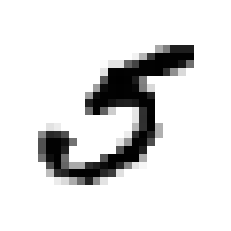

5.0

In [4]:
"""
共有 7 万张图片 , 每张图片有 784 个特征。图片是 28 * 28 的像素
每个特征代表一个像素点的强度  0(white) - 255(black)
"""
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image , cmap = matplotlib.cm.binary , interpolation = 'nearest')
plt.axis('off')
plt.show()

y[36000]

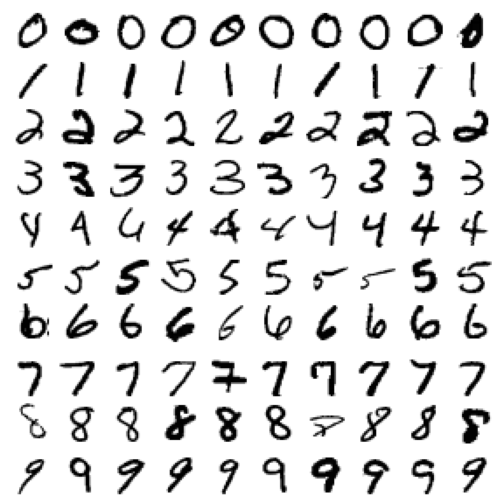

In [5]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
 
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
# save_fig("more_digits_plot")
plt.show()


In [6]:
"""
取前 6w 张图片来作训练的数据 ， 后面的数据来作为测试集
"""

X_train , X_test , y_train , y_test = X[:60000] , X[60000:] , y[:60000] , y[60000:]

# 打乱训练集合的数据 permutation 是具有返回值的
shuffle_index = np.random.permutation(60000)
X_train , y_train = X_train[shuffle_index] , y_train[shuffle_index]

print(X_train)
print(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0. 2. 8. ... 6. 5. 8.]


In [7]:
"""
训练一个二元的分类器
"""

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train , y_train_5)
sgd_clf.predict([some_digit])

array([False])

In [7]:
"""
使用交叉验证测试精度
"""

# StratifielKFold 执行分成抽样
skfolds = StratifiedKFold(n_splits = 3 , random_state = 42 , shuffle = True)

# 分三层来进行抽样然后来计算出正确率
for train_index , test_index in skfolds.split(X_train , y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds , y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_test_folds))

0.9657
0.9684
0.9695


In [8]:
"""
使用 cross_val_score() 函数来评估 SGDClassifier 模型 采用 K-fold 交叉验证法 ， 3个折叠
"""

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf , X_train , y_train_5 , cv = 3 , scoring = "accuracy")

array([0.9516 , 0.96665, 0.96675])

In [9]:
"""
尝试写一个分类器将每张图分类成 非 '5'
"""


from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self , X , y = None):
        pass
    def predict(self , X):
        return np.zeros((len(X) , 1) , dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf , X_train , y_train_5 , cv = 3 , scoring = "accuracy")    # 若正确率很高只能说明数据集中的 5 的数量非常的少

array([0.91175, 0.9087 , 0.9085 ])

In [10]:
"""
评估分类器性能的最好方法：采取混淆矩阵的方法
    思路：统计 A 类别实例被分成为 B 类别的次数
    
    要计算混淆矩阵需要先有一组预测才能将其与实际目标进行比较。
"""

from sklearn.model_selection import cross_val_predict

# cross_val_predict() 函数同样执行 K-fold 交叉的验证但是返回的不是评估分数而是每个折叠的预测
y_train_pred = cross_val_predict(sgd_clf , X_train , y_train_5 , cv = 3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [11]:
"""
confusion_matrix() 函数来获取混淆矩阵
混淆矩阵的行表示实际类型  列表示预测类型
"""

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5 , y_train_pred)

# 如下的预测结果可以说明：
#         53459 张被正确地分为 非'5' 类型    1120 张被错误的分为 '5' 类型
#         1180  张被错误的分为 非'5' 类型    4241 张被正确的分为 '5' 类型
#     
#                  预测
#              非5      5
#  实  非5    53459    1120
#  际   5     1180     4241

array([[53459,  1120],
       [ 1180,  4241]], dtype=int64)

In [12]:
"""
正类预测的准确率指标：精度公式 (正类预测的准确率)
        精度 = TP / （TP + FP） --- "相当于 TP + FP 中预测对了 TP 个"
        TP : 真正类的数量
        FP : 假正类的数量
精度通常与另一个指标一起使用 , 这个指标是召回率 (分类器正确检测到的正类实例的比率) 
        召回率 = TP / (TP + FN)
        FN : 假负类的数量       --- "相当于 TP + FN 中找出了 TP 个"
"""

from sklearn.metrics import precision_score , recall_score

print("精度 : " ,precision_score(y_train_5 , y_train_pred))
print("召回率 : " , recall_score(y_train_5 , y_train_pred))

精度 :  0.7910837530311509
召回率 :  0.7823279837668327


In [13]:
"""
将精度和召回率组合成一个单一的指标 称为 F1 分数
F1 分数是精度和召回率的谐波平均值，正常的平均值平等对待所有的值 , 而谐波平均值会给予较低的值更高的权重。
因此只有当精度和召回率都高的时候，分类器才能得到较高的 F1 分数。
                   2
公式： F1 = -----------------
             1          1
            ----   +  ------
            精度      召回率

计算 F1 分数只需调用 f1_score() 函数即可
"""

from sklearn.metrics import f1_score
f1_score(y_train_5 , y_train_pred)

0.7866815062140604

[4448.79734002]


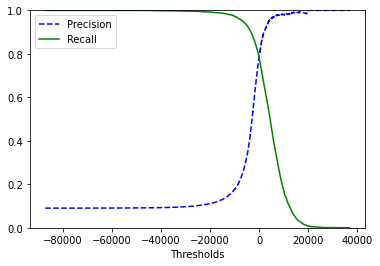

In [14]:
"""
精度 / 召回率 权衡

Scikit-Learn 不允许直接设置阈值 , 但是可以访问它用于预测的决策分数。
不是调用 predict() 方法，而是调用 decision_function() 方法，这个方法返回每个实例的分数，
然后就可以根据这些分数，实现任意阈值的预测
"""

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)



y_scores = cross_val_predict(sgd_clf , X_train , y_train_5 , cv = 3 , method = "decision_function")

from sklearn.metrics import precision_recall_curve
# 使用 precision_call_curve() 函数来计算所有可能的阈值的精度和召回率
precisions , recalls , thresholds = precision_recall_curve(y_train_5 , y_scores)

def plot_precision_recall_vs_threshold(precisions , recalls , thresholds):
    plt.plot(thresholds , precisions[:-1] , "b--" , label = "Precision")
    plt.plot(thresholds , recalls[:-1] , "g-" , label = "Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc = "upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions , recalls , thresholds)
plt.show()

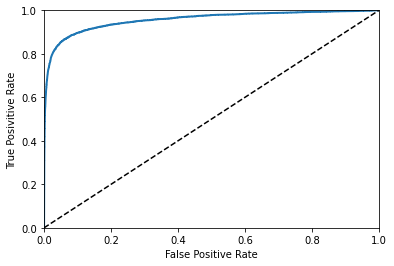

In [15]:
"""
Roc 曲线绘制的是真正类率(召回率的另一个名称) ， 和假正类率(FPR)。
    FPR 是被错误分为正类的负类的比列 等于 ：1 - 真负类率(TNR : 被正确分类为负类的负类实例比率也称为特异度)
    所以 Roc 曲线绘制的是 灵敏度 和 1 - 特异度 的关系
"""

from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(y_train_5 , y_scores)

def plot_roc_curve(fpr , tpr , label = None):
    plt.plot(fpr , tpr , linewidth = 2 , label = label)
    plt.plot([0,1] , [0,1] , 'k--')
    plt.axis([0 , 1 , 0 , 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posivitive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [18]:
"""
一种比较分类器的方法：测量曲线下面积 (AUC)
完美的分类器的 ROC AUC = 1 , 纯随机的分类器的 ROC AUC = 0.5
"""

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5 , y_scores)

0.9561431033939829

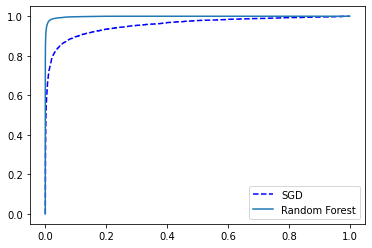

In [24]:
"""
训练一个 RandomForestClassifier 分类器 ， 并比较他和 SGDClassifier 分类器的 ROC AUC 分数
"""
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf , X_train , y_train_5 , cv = 3 , method = "predict_proba")

y_scores_forest = y_probas_forest[: , 1]    # score = proba of positive class
fpr_forest , tpr_forest , threshold_forest = roc_curve(y_train_5 , y_scores_forest)


plt.plot(fpr , tpr , "b--" , label = "SGD")
plt.plot(fpr_forest , tpr_forest , label = "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [26]:
roc_auc_score(y_train_5 , y_scores_forest)

0.9984789779176663

In [28]:
"""
多类别的分类器
"""

# Scikit-Learn 实际上训练了 10 个二元分类器，获得它们对图片的决策分数，然后选择了分数最高的类别
sgd_clf.fit(X_train , y_train)
print(sgd_clf.predict([some_digit]))

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

[5.]


array([[-10509.98255154, -26318.57102697, -15237.83502646,
         -5130.45518439, -18887.83596763,   5926.80693663,
        -24910.29670063, -20757.91292089, -14450.99423509,
        -15416.72145497]])

In [30]:
"""
目标类别的列表会存储再 classes_ 这个属性中 按值的大小排序
"""

print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)

5
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [39]:
"""
如果要强制 Scikit-Learn 使用一对一或者一对多策略 , 可以使用 OneVsOneClassifier 或 OneVsRestClassifier 类。
只需创建一个实例 然后将二元分类器传给其构造函数
"""

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train , y_train)
print(ovo_clf.predict([some_digit]))

print(len(ovo_clf.estimators_))    # 使用了 N * (N - 1) / 2 个分类器s                      

[3.]
45


In [41]:
"""
训练 RandomForestClassifier
"""
forest_clf.fit(X_train , y_train)
print(forest_clf.predict([some_digit]))

forest_clf.predict_proba([some_digit])

[5.]


array([[0.04, 0.01, 0.  , 0.02, 0.  , 0.91, 0.01, 0.01, 0.  , 0.  ]])

In [ ]:
"""
将输入进行简单的缩放 来提升准确率
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf , X_train_scaled , y_train , cv = 3 , scoring = "accuracy")

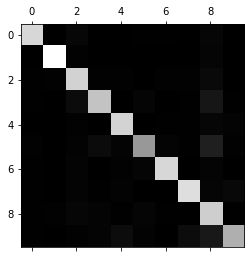

In [49]:
"""
错误分析
"""

y_train_pred = cross_val_predict(sgd_clf , X_train , y_train , cv = 3)
conf_mx = confusion_matrix(y_train , y_train_pred)
conf_mx

plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

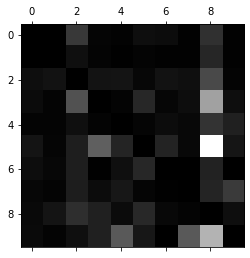

In [54]:
"""
比较错误率
"""

row_nums = conf_mx.sum(axis = 1 , keepdims = True)
norm_conf_mx = conf_mx / row_nums                     # 将混淆矩阵中的每个值除以相应类别中的图片的数量

np.fill_diagonal(norm_conf_mx , 0)
plt.matshow(norm_conf_mx , cmap = plt.cm.gray)
plt.show()

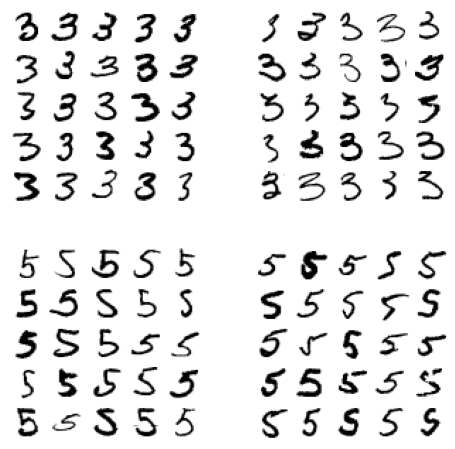

In [65]:
"""
分析单个错误
"""

cl_a , cl_b = 3 , 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize = (8,8))

plt.subplot(221); plot_digits(X_aa[:25] , images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25] , images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25] , images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25] , images_per_row = 5)

plt.show()

In [8]:
"""
多标签的分类
"""

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large , y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train , y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

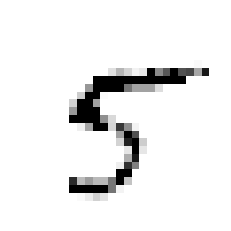

In [79]:
"""
多输出分类
"""

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test



# def plot_digit(data):
#     image = data.reshape(28, 28)
#     plt.imshow(image, cmap = matplotlib.cm.binary,
#                interpolation="nearest")
#     plt.axis("off")
    
# some_index = 5500
 
# plt.subplot(121); plot_digit(X_test_mod[some_index])
# plt.subplot(122); plot_digit(y_test_mod[some_index])
# plt.show()


knn_clf.fit(X_train_mod , y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [18]:
# Choose the best model to test

model = KNeighborsClassifier()
model.fit(X_train , y_train)

KNeighborsClassifier()

In [19]:
false_num = 0
true_num = 0

for i in range(10000):
    predict_num = model.predict([X_test[i]])
    real_num = y_test[i]
    if(predict_num[0] != real_num):
        false_num += 1
        print("Prediction : {}  ,  Real : {}".format(predict_num , real_num))
    else:
        true_num += 1

        
print("错误预测的个数 ： " , false_num)
print("正确的预测个数 : " , true_num)
print("正确率 : " , true_num / (false_num + true_num))

Prediction : [2.]  ,  Real : 0.0
Prediction : [7.]  ,  Real : 0.0
Prediction : [5.]  ,  Real : 0.0
Prediction : [6.]  ,  Real : 0.0
Prediction : [1.]  ,  Real : 0.0
Prediction : [6.]  ,  Real : 0.0
Prediction : [2.]  ,  Real : 1.0
Prediction : [2.]  ,  Real : 1.0
Prediction : [0.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [8.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [4.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [0.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [0.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [1.]  ,  Real : 2.0
Prediction : [0.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [1.]  ,  Real : 2.0
Prediction : [0.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction : [6.]  ,  Real : 2.0
Prediction : [1.]  ,  Real : 2.0
Prediction : [1.]  ,  Real : 2.0
Prediction : [3.]  ,  Real : 2.0
Prediction : [7.]  ,  Real : 2.0
Prediction

Prediction : [7.]  ,  Real : 8.0
Prediction : [6.]  ,  Real : 8.0
Prediction : [0.]  ,  Real : 8.0
Prediction : [6.]  ,  Real : 8.0
Prediction : [2.]  ,  Real : 8.0
Prediction : [4.]  ,  Real : 8.0
Prediction : [5.]  ,  Real : 8.0
Prediction : [0.]  ,  Real : 8.0
Prediction : [6.]  ,  Real : 8.0
Prediction : [9.]  ,  Real : 8.0
Prediction : [1.]  ,  Real : 8.0
Prediction : [9.]  ,  Real : 8.0
Prediction : [3.]  ,  Real : 8.0
Prediction : [4.]  ,  Real : 8.0
Prediction : [5.]  ,  Real : 8.0
Prediction : [5.]  ,  Real : 8.0
Prediction : [8.]  ,  Real : 9.0
Prediction : [7.]  ,  Real : 9.0
Prediction : [3.]  ,  Real : 9.0
Prediction : [8.]  ,  Real : 9.0
Prediction : [4.]  ,  Real : 9.0
Prediction : [3.]  ,  Real : 9.0
Prediction : [3.]  ,  Real : 9.0
Prediction : [3.]  ,  Real : 9.0
Prediction : [3.]  ,  Real : 9.0
Prediction : [4.]  ,  Real : 9.0
Prediction : [2.]  ,  Real : 9.0
Prediction : [1.]  ,  Real : 9.0
Prediction : [6.]  ,  Real : 9.0
Prediction : [1.]  ,  Real : 9.0
Prediction